In [6]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import plot_tree

# Pipeline
from tree import TreeModel

# ===== import data; tr,ts ======
X_tr = pd.read_csv('split-data/processed/X_tr.csv')
X_ts = pd.read_csv('split-data/processed/X_ts.csv')
y_tr = pd.read_csv('split-data/processed/y_tr.csv')
y_ts = pd.read_csv('split-data/processed/y_ts.csv')

In [2]:
# ===== Gradient Boosting ======
start = time.time()

gb_params = {
    'X_tr': X_tr.to_numpy(),
    'X_ts': X_ts.to_numpy(),
    'y_tr': y_tr.values.ravel(),
    'y_ts': y_ts.values.ravel(),
    'model': GradientBoostingClassifier(),
    'name': 'Gradient Boosting'
}

gb_pipeline = TreeModel(**gb_params)

gb_fit_params = {
    'param_grid': {
        'n_estimators': [50, 100, 200, 500, 1000],
        'learning_rate': [0.01, 0.1, 0.5, 1.0],
        'max_depth': [1, 3, 5]
    },
    'balance_classes': False,
    'k_folds': 2,
    'scoring': 'accuracy'
}

gb_pipeline.fit_predict(**gb_fit_params)

end = time.time()
elapsed = end - start
print(f"Elapsed time: {elapsed:.2f} seconds")

Elapsed time: 416.30 seconds


In [3]:
gb_pipeline.tr_ts_scoring

print("Best Hyperparameters:", gb_pipeline.grid.best_params_)

GradientBoostingClassifier()
Grid - Hyperparameters: ['n_estimators', 'learning_rate', 'max_depth']
Train Accuracy: 88.190%
CV Validation Accuracy: 86.480%
Test Accuracy: 86.939%
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}


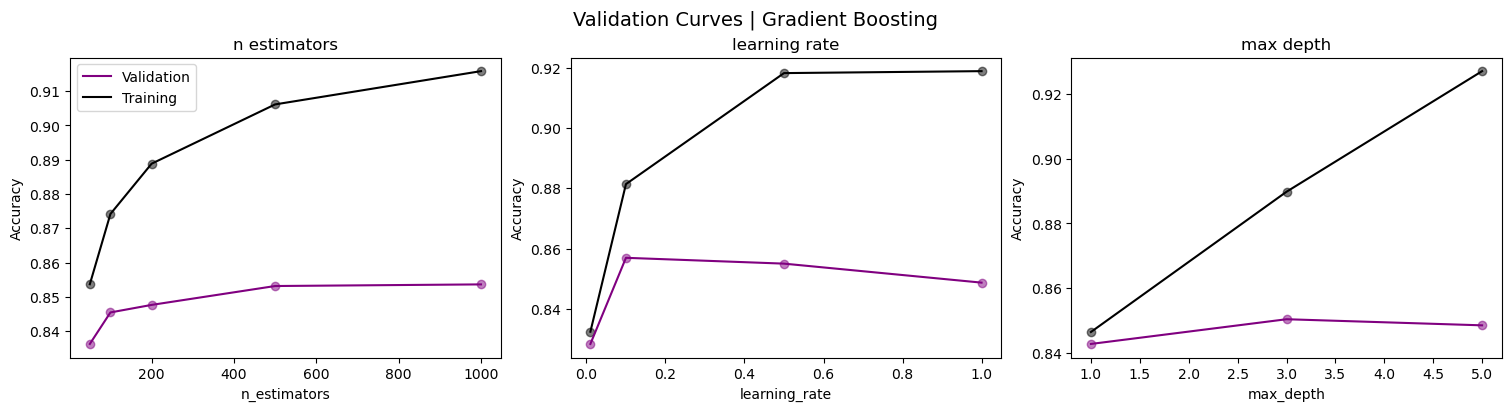

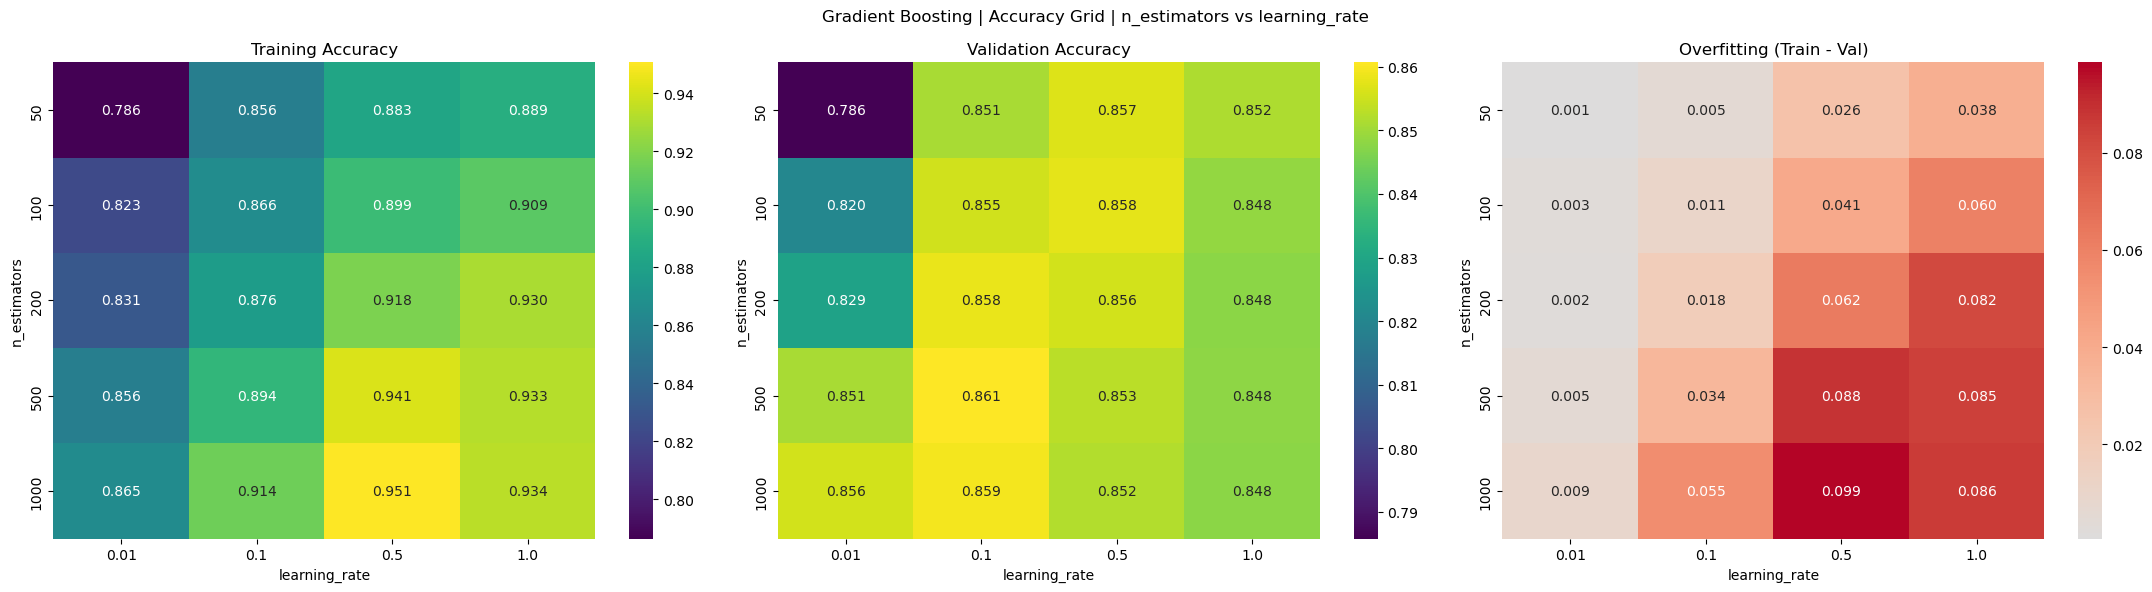

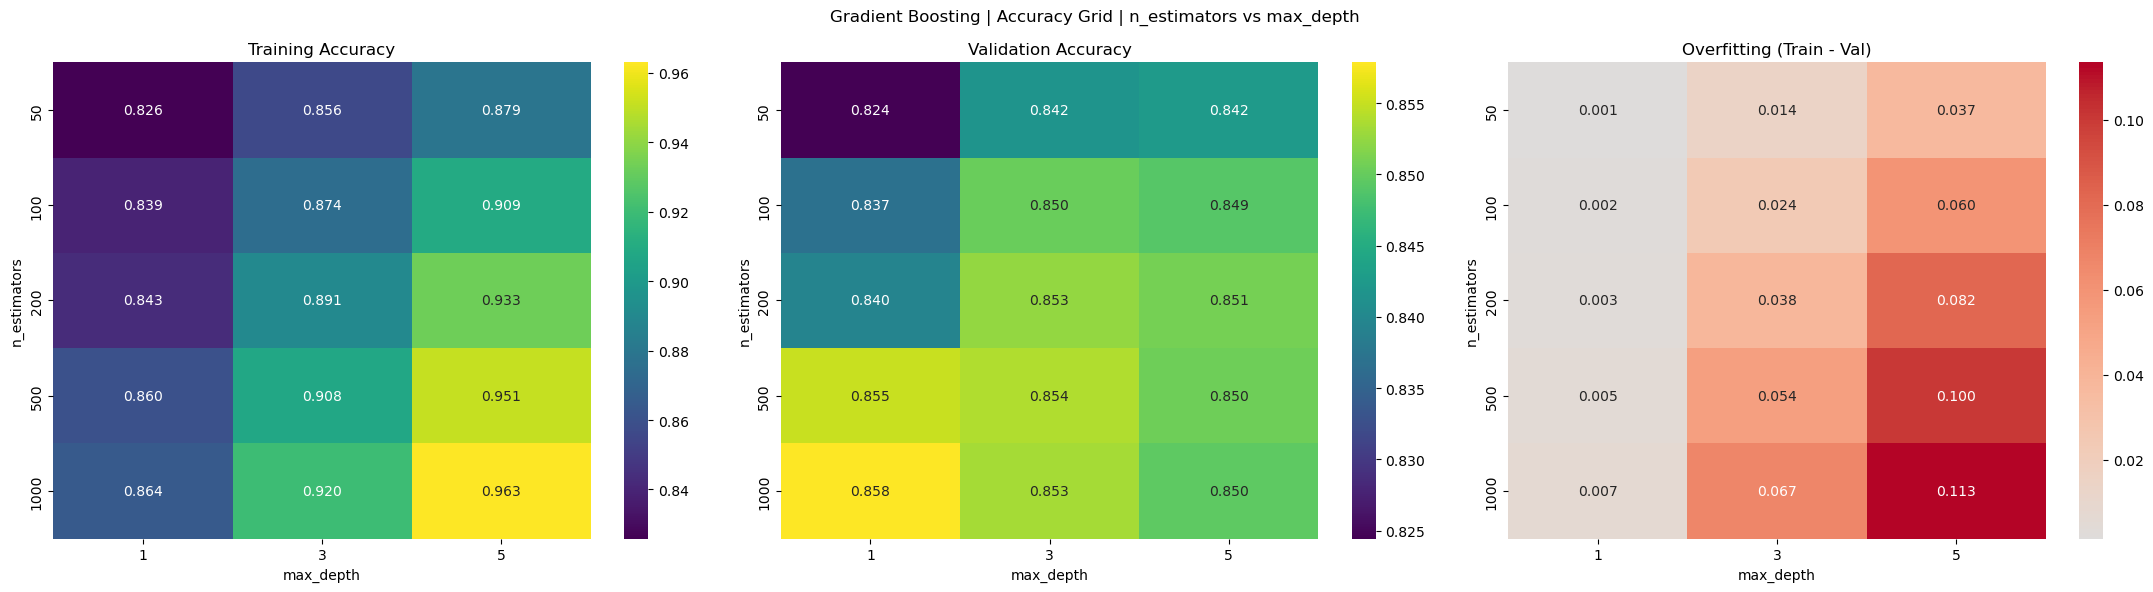

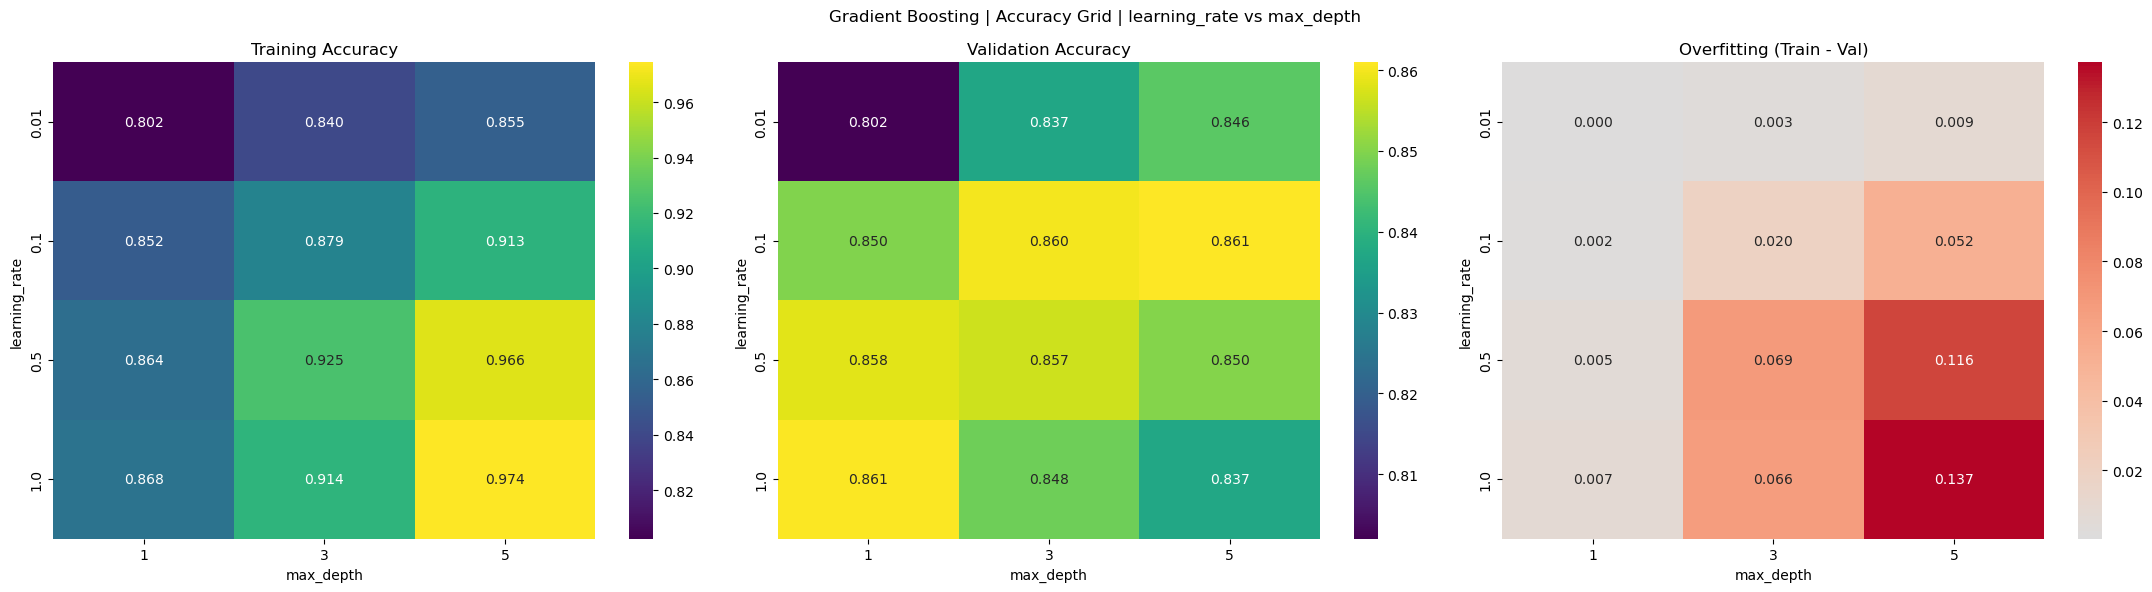

In [4]:
# ===== Gradient Boosting Scoring & Visualization ======
os.makedirs('media/05_gradient_boosting', exist_ok=True)

plot_vhgr_params = {
    'param_list': gb_pipeline.hyper_grid,
    'figsize': (5, 4),
    'save_path': 'media/05_gradient_boosting/validation_curves.png'
}
gb_pipeline.plot_validation_hyperparam_grid_row(**plot_vhgr_params)

gb_pipeline.viz_heatmap_cv(
    top_two_params_for_overfitting=['n_estimators', 'learning_rate'],
    dir_save_path='media/05_gradient_boosting'
)

gb_pipeline.viz_heatmap_cv(
    top_two_params_for_overfitting=['n_estimators', 'max_depth'],
    dir_save_path='media/05_gradient_boosting'
)

gb_pipeline.viz_heatmap_cv(
    top_two_params_for_overfitting=['learning_rate', 'max_depth'],
    dir_save_path='media/05_gradient_boosting'
)

For the most part, all three of these hyperparameters have training accuracy that diverges from validation accuracy which is a signal of overfitting!

In [9]:
print(gb_model.estimators_.shape)


(500, 1)


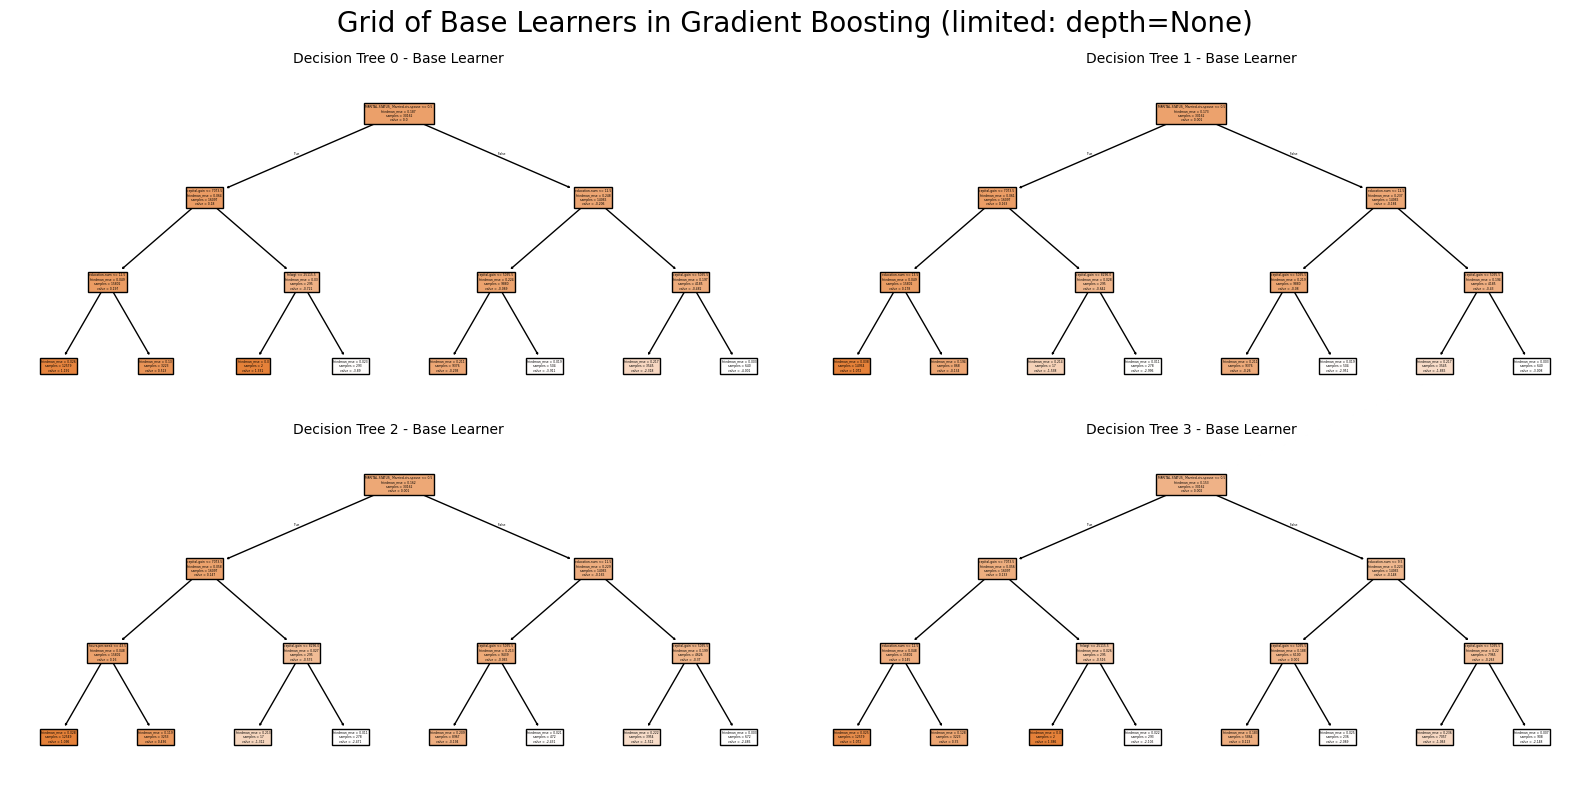

In [20]:
gb_model = gb_pipeline.grid.best_estimator_
depth = None

cols = 2
fig, axes = plt.subplots(2, cols, figsize=(16, 8))
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(2 * cols):
    ax = axes[i]
    plot_tree(
        gb_model.estimators_[i, 0],
        filled=True,
        max_depth=depth,
        feature_names=X_tr.columns,
        ax=ax
    )
    ax.set_title(f'Decision Tree {i} - Base Learner', fontsize=10)

plt.suptitle(f'Grid of Base Learners in Gradient Boosting (limited: depth={depth})', fontsize=20)
plt.tight_layout()
plt.savefig('media/05_gradient_boosting/base_learner_viz.png', bbox_inches='tight')
plt.show()

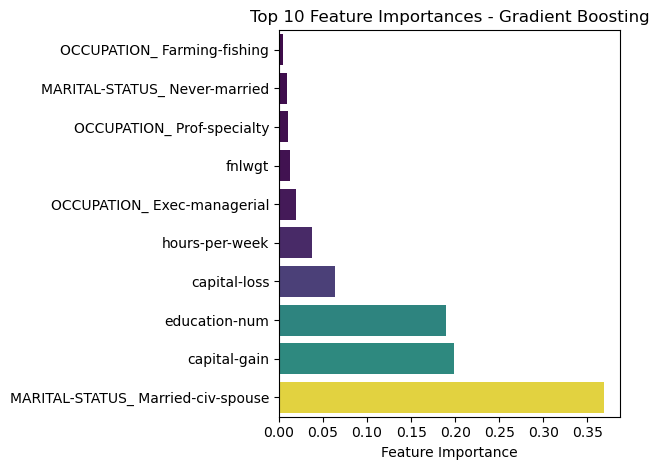

In [5]:
# ===== Gradient Boosting Feature Importances ======
k = 10
best_gb = gb_pipeline.grid.best_estimator_

gb_importances = pd.Series(best_gb.feature_importances_, index=X_tr.columns)
top_features = gb_importances.sort_values(ascending=False).head(k)

sns.barplot(
    x=top_features.sort_values().values,
    y=top_features.sort_values().index,
    hue=top_features.sort_values().values,
    dodge=False,
    palette='viridis',
    legend=False
)

plt.title(f"Top {k} Feature Importances - Gradient Boosting")
plt.xlabel("Feature Importance")
plt.ylabel('')
plt.tight_layout()
plt.savefig('media/05_gradient_boosting/significant_features_viz.png')
plt.show()